In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.io import ascii

from scipy import stats, interpolate
from scipy.integrate import quad, cumtrapz
from scipy.optimize import curve_fit

import sys
sys.path.append('../../')
import magnification_library as magnification_library
from magnification_library import *


import clmm
from clmm import utils 
import pyccl

from importlib import reload  


import clmm
from clmm.support.sampler import fitters

In [2]:
reload(magnification_library)

<module 'magnification_library' from '../../magnification_library.py'>

In [3]:
clmm.__version__

'1.0.0'

In [4]:
#define cosmology

#from https://arxiv.org/pdf/1904.13378.pdf%20for%20u-dropout BEWARE that CT backend can not handle sigma8

#astropy object
cosmo = FlatLambdaCDM(H0=67.7, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [5]:
def get_halo_concentration(mass_lens, z_lens, cosmo_ccl, relation="Diemer15", mdef="matter", delta_so=200):
    mdef = pyccl.halos.massdef.MassDef(delta_so, mdef, c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_clmm.be_cosmo, M=mass_lens, a=cosmo_clmm.get_a_from_z(z=z_lens), mdef_other=mdef)
    return conc 

# **1) Lens and sources properties**

## **Lens**

In [6]:
#lens properties 
z_cl = [0.1, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5]
M200_cl = np.array([5e13, 1e14, 2.5e14, 5e14,1e15])

r200, c200 = np.zeros((2, len(M200_cl), len(z_cl)))
for i in range(len(z_cl)):
    r200[:, i] = scaled_radius(200, M200_cl, z_cl[i], cosmo)
    
c200 = np.zeros((len(M200_cl),len(z_cl)))
for i in np.arange(len(z_cl)):
    for j in np.arange(len(M200_cl)):
        c200[j,i] = get_halo_concentration(M200_cl[j], z_cl[i], cosmo_clmm, "Diemer15")
    

Text(0, 0.5, 'c200')

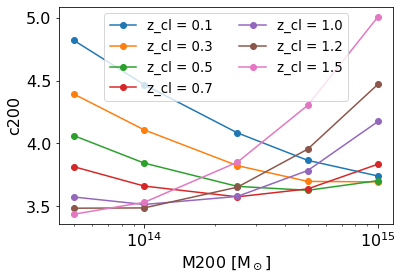

In [7]:
for i in range(len(z_cl)):
    plt.semilogx(M200_cl, c200[:,i], 'o-',  label = 'z_cl = '+str(z_cl[i]));

plt.legend(ncol=2, fontsize='small')

plt.xlabel('M200 [M$_\odot$]')
plt.ylabel('c200')

## lens expected number counts 

In [8]:
mass_def = pyccl.halos.MassDef200m()
hmf = pyccl.halos.MassFuncTinker10(cosmo_ccl, mass_def = mass_def) #dn/dlog10M
#corr = 1./(M200_cl*np.log(10)) #pour passer en dn/dM
corr = 1

In [9]:
Area = 18000 * u.deg**2
Omega = Area.to(u.sr)

X = pyccl.comoving_radial_distance(cosmo_ccl, a = 1./(1+np.array(z_cl))) * u.Mpc
Hz = pyccl.background.h_over_h0(cosmo_ccl, 1/(1+np.array(z_cl) )) * cosmo_ccl.cosmo.params.H0

dVdz = 1/u.sr *  (pyccl.physical_constants.CLIGHT * u.m/u.s ).to(u.km/u.s)  / (Hz * u.km/(u.Mpc*u.s)) *  X**2 
# similar to  cosmo.be_cosmo.differential_comoving_volume(np.array(z_cl))

Volume = dVdz * Omega

In [10]:
N_hmf = np.array([corr * hmf.get_mass_function(cosmo_ccl, M200_cl, 1./(1+np.array(z_cl[i])) ) for i in range(len(z_cl))])
N_halo = np.array([N_hmf[i,:] * Volume[i].value for i in range(len(z_cl))])

Text(0, 0.5, 'M200 [$M_{\\odot}$]')

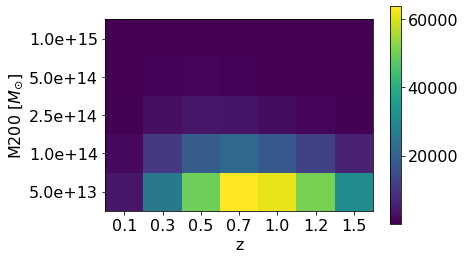

In [11]:
dz = 0.05*2
dlog10m = 0.1
#dm = 0.5*1e13


plt.imshow(N_halo.T*dz*dlog10m,origin='lower')#,extent = [np.array(z_cl).min(), np.array(z_cl).max(), np.array(M200_cl).min(), np.array(M200_cl).max()], aspect='auto')
plt.xticks(np.arange(0,len(z_cl)), [0.1, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5])
plt.yticks(np.arange(0,len(M200_cl)), ['5.0e+13', '1.0e+14', '2.5e+14', '5.0e+14', '1.0e+15'])
plt.colorbar()
plt.xlabel('z')
plt.ylabel('M200 [$M_{\odot}$]')

## **Sources**

In [12]:
#Source galaxies properties 
#(source shear shot noise or LF slope, source density, redshift distribution parametrization)

#SHEAR LSST__________________________________________________________________
# fiducial number for Y10 (Y1) after blending + masking https://arxiv.org/pdf/1305.0793.pdf
s_e = 0.26
n_e_Y10 = 26 /u.arcmin**2
n_e_Y1 = 9 /u.arcmin**2

def shear_pdz(z):
    norm =quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3), 0, np.inf)[0]
    return pdf_z(z, 1.24, 1.01, 0.51)*np.heaviside(z>0,0)*np.heaviside(z<3.,0)/norm

#MAGNIFICATION LSST u-dropout_________________________________________________________
#see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for u-dropout

LF_param = {'z_eff':[2.,3.,3.8,4.9,5.9], 'phi_star':[97.0,50.4,92.5,32.2,16.4]*1/(cosmo.h*u.Mpc**3), 'alpha':[-1.60,-1.78,-1.57,-1.60,-1.87], 'm_star_UV':[24.2,24.7,25.4,25.5,25.8]}

#At z~3 the LSST band corresponding to UV ~ 1500 Angstrom is the r band.
#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlimY1 = 25.81 #r band
mlimY10 = 27.04 #r band

alpha_lbg_Y1 = 2.5 * slope(mlimY1, LF_param['alpha'][1], LF_param['m_star_UV'][1], beta=None,fct="schechter")
alpha_lbg_Y10 = 2.5 * slope(mlimY10, LF_param['alpha'][1], LF_param['m_star_UV'][1], beta=None,fct="schechter")
n_eff_lbg_Y1 = (1.8e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 
n_eff_lbg_Y10 = (7.5*1e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 

def mu_lbg_pdz(z):
    func = gaussian(z, 1, 2.96,0.61/(2*np.sqrt(2*np.log(2))))
    return func/quad(lambda z: gaussian(z, 1, 2.96,0.61/(2*np.sqrt(2*np.log(2)))), 0, np.inf)[0]


#MAGNIFICATION LSST BX-dropout_________________________________________________________
#see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for BX-dropouts

#At z~2 the LSST band corresponding to UV ~ 1500 Angstrom is the g band.
#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlimY1g =  25.60 #g band
mlimY10g = 26.84 #g band

alpha_bx_Y1 = 2.5 * slope(mlimY1g, LF_param['alpha'][0], LF_param['m_star_UV'][0], beta=None,fct="schechter")
alpha_bx_Y10 = 2.5 * slope(mlimY10g, LF_param['alpha'][0], LF_param['m_star_UV'][0], beta=None,fct="schechter")

n_eff_bx_Y1 = (3e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 
n_eff_bx_Y10 = (3.*1e5/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 

def mu_bx_pdz(z):
    func = gaussian(z, 1, 2.20,0.80/(2*np.sqrt(2*np.log(2))))
    return func/quad(lambda z: gaussian(z, 1, 2.20,0.80/(2*np.sqrt(2*np.log(2)))), 0, np.inf)[0]


#MAGNIFICATION Euclid/WFIRST Halpha_________________________________________________________
#https://arxiv.org/pdf/1710.00833.pdf

alpha_ha =  2. #based on manual check
n_eff_ha = (0.5 * 4256./(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 
#based on 1/3 * (counts_Ferr + counts_Cal + counts_Char) f>2x10^{-16} + 50% estimation probability to measure the redshift

def halpha_pdz(z):
    """Redshift distribution function"""
    #func = np.heaviside((z>0.9),0)*np.heaviside((z<1.8),0)*(z**0.106482)*np.exp(-(z/0.58316767))
    func = np.heaviside((z>0.9),0)*np.heaviside((z<1.8),0)*(z**0.106482)*np.exp(-(z/0.58316767))
    return func/quad(lambda z: np.heaviside((z>0.9),0)*np.heaviside((z<1.8),0)*(z**0.106482)*np.exp(-(z/0.58316767)), 0, np.inf)[0]

#MAGNIFICATION DESI QSO_________________________________________________________
alpha_qso =  2.5 *0.197 #for QSO based on last raw of Table 1 in https://www.aanda.org/articles/aa/pdf/2017/12/aa31850-17.pdf
n_eff_qso = (170/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) #based on Table 3.1 in https://arxiv.org/pdf/1611.00036.pdf (measured redshift)

def mu_qso_pdz(z):
    norm =quad(QSO_pdf_z, 0, np.inf)[0]
    return QSO_pdf_z(z)/norm

mslope_z = -99

# **2) Model computation**

In [13]:
n_e = n_e_Y1
n_eff_dmu = n_eff_lbg_Y1
alpha_dmu = alpha_lbg_Y1
dmu_pdz = mu_lbg_pdz

dict_profile = {'reduced shear': \
                {'model_func':  clmm.theory.compute_tangential_shear, \
                'noise_func': lambda Ngal: noise_shear(Ngal , s_e),\
                'model_arg': 1., \
                'source_pdz': shear_pdz,\
                'source_density': n_e,\
                'delta_z_cut' : 0.1}, \
                'density contrast': \
                {'model_func':  clmm.theory.compute_magnification, \
                'noise_func': noise_mag,\
                'model_arg': alpha_dmu, \
                'source_pdz': dmu_pdz,\
                'source_density': n_eff_dmu,\
                'delta_z_cut' : 0.1}, \
                'redshift depth contrast': \
                {'model_func':  clmm.theory.compute_magnification, \
                'noise_func': lambda Ngal: noise_zdepth(Ngal , mu_qso_pdz),\
                'model_arg': 2.5*mslope_z, \
                'source_pdz': mu_qso_pdz,\
                'source_density': n_eff_qso,\
                'delta_z_cut' : 0.1}}

In [14]:
lens_redshift = z_cl
radial_unit, rmin, rmax = 'Mpc', 0.1, 8.
nbins = 10
method = 'evenlog10width'

In [15]:
bin_center_s, noise_s = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_s = np.zeros((nbins + 1, len(lens_redshift)))
model_s = np.zeros((nbins, len(M200_cl), len(lens_redshift)))

for i in range(len(lens_redshift)):
    conc = get_halo_concentration(M200_cl, lens_redshift[i], cosmo_clmm, "Diemer15")
    bin_center_s[:,i], bin_edges_s[:,i], noise_s[:,i], model_s[:,:,i] = \
    profile_determination(rmin, rmax, radial_unit , lens_redshift[i], M200_cl , "reduced shear",\
                          dict_profile, cosmo_clmm,   nbins=nbins, method=method,\
                          conc=conc, delta_mdef=200, zinf=1000)

In [16]:
bin_center_mu_lbg, noise_mu_lbg = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_mu_lbg = np.zeros((nbins + 1, len(lens_redshift)))
model_mu_lbg = np.zeros((nbins, len(M200_cl), len(lens_redshift)))

for i in range(len(lens_redshift)):
    conc =  get_halo_concentration(M200_cl, lens_redshift[i], cosmo_clmm, "Diemer15")
    bin_center_mu_lbg[:,i], bin_edges_mu_lbg[:,i], noise_mu_lbg[:,i] , model_mu_lbg[:,:,i] = \
            profile_determination(rmin, rmax, radial_unit , lens_redshift[i], M200_cl ,\
                                  "density contrast" , dict_profile, cosmo_clmm,   nbins=nbins, method=method,\
                                  conc=conc, delta_mdef=200, zinf=1000)

In [17]:
bin_center_mu_qso, noise_mu_qso = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_mu_qso = np.zeros((nbins + 1, len(lens_redshift)))
model_mu_qso = np.zeros((nbins, len(M200_cl), len(lens_redshift)))
modelz_mu_qso = np.zeros((nbins, len(M200_cl), 10000, len(lens_redshift)))

for i in range(len(lens_redshift)):
    conc =  get_halo_concentration(M200_cl, lens_redshift[i], cosmo_clmm, "Diemer15")
    bin_center_mu_qso[:,i], bin_edges_mu_qso[:,i], noise_mu_qso[:,i], model_mu_qso[:,:,i], modelz_mu_qso[:,:,:,i] = \
            profile_determination(rmin, rmax, radial_unit , lens_redshift[i], M200_cl ,\
                                  "redshift depth contrast" ,dict_profile, cosmo_clmm,   nbins=nbins, method=method ,\
                                  conc=conc, delta_mdef=200, zinf=1000)

/pbs/throng/lsst/users/mricci/desc/CLMM/clmm/theory/func_layer.py:532: UserWarning: Some source redshifts are lower than the cluster redshift. magnification = 1 for those galaxies.
  warnings.warn(
../../magnification_library.py:232: RuntimeWarning: invalid value encountered in power
  model_z[i,j,:] = dict_profile[profile_type]['model_func'](rad_Mpc[i], mdelta=mass[j],


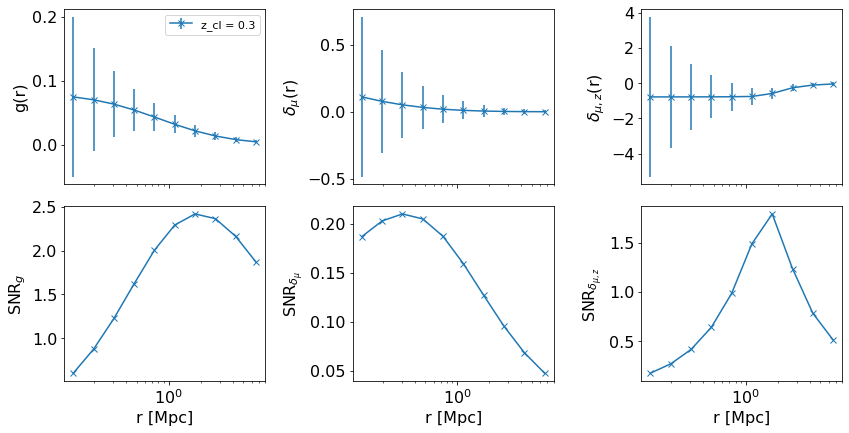

In [18]:
fig, ax = plt.subplots(2, 3,  figsize=(12,6), sharex=True, sharey=False)

i,j = 4,1

ax[0,0].errorbar(bin_center_s[:,j], model_s[:,i, j], yerr = noise_s[:,j], fmt='-x',  label = 'z_cl = '+str(lens_redshift[j]))
ax[1,0].plot(bin_center_s[:,j], abs(model_s[:,i, j])/noise_s[:,j],'-x',  label = 'z_cl = '+str(lens_redshift[j]))

ax[0,1].errorbar(bin_center_mu_lbg[:,j], model_mu_lbg[:,i, j], yerr = noise_mu_lbg[:,j], fmt='-x',  label = 'z_cl = '+str(lens_redshift[j]))
ax[1,1].plot(bin_center_mu_lbg[:,j], abs(model_mu_lbg[:,i, j])/noise_mu_lbg[:,j],'-x',  label = 'z_cl = '+str(lens_redshift[j]))

ax[0,2].errorbar(bin_center_mu_qso[:,j], model_mu_qso[:,i, j], yerr = noise_mu_qso[:,j], fmt='-x',  label = 'z_cl = '+str(lens_redshift[j]))
ax[1,2].plot(bin_center_mu_qso[:,j], abs(model_mu_qso[:,i, j])/noise_mu_qso[:,j],'-x',  label = 'z_cl = '+str(lens_redshift[j]))


#ax[0,0].set_xlim(0.2, 3.5)
ax[0,0].legend(ncol=2, fontsize='x-small', loc="best")
ax[0,0].set_xscale('log')

ax[0,0].set_ylabel('g(r)')
ax[1,0].set_ylabel('SNR$_g$')

ax[0,1].set_ylabel('$\delta_{\mu}$(r)')
ax[1,1].set_ylabel('SNR$_{\delta_{\mu}}$')

ax[0,2].set_ylabel('$\delta_{\mu,z}$(r)')
ax[1,2].set_ylabel('SNR$_{\delta_{\mu,z}}$')

fig.tight_layout()

[ax[1,i].set_xlabel('r [' + radial_unit + ']') for i in [0,1,2]];

# **3) $\chi^2$ minimization to constrain the mass**

In [19]:
def predict_function_reduced_shear(radius_Mpc, logM, z_cl):
    M_guess = 10**logM
    conc_guess = get_halo_concentration(M_guess, z_cl, cosmo_clmm, "Diemer15")
    return modele_determination(radius_Mpc, radial_unit, z_cl, M_guess, 'reduced shear', \
                                                     dict_profile, cosmo_clmm, conc=conc_guess, delta_mdef=200, zinf=1000)

def predict_function_density_contrast(radius_Mpc, logM, z_cl):
    M_guess = 10**logM
    conc_guess = get_halo_concentration(M_guess, z_cl, cosmo_clmm, "Diemer15")
    return modele_determination(radius_Mpc, radial_unit, z_cl, M_guess, 'density contrast', \
                                                     dict_profile, cosmo_clmm, conc=conc_guess, delta_mdef=200, zinf=1000)

def predict_function_redshift_depth_contrast(radius_Mpc, logM, z_cl):
    M_guess = 10**logM
    conc_guess = get_halo_concentration(M_guess, z_cl, cosmo_clmm, "Diemer15")
    return modele_determination(radius_Mpc, radial_unit, z_cl, M_guess, 'redshift depth contrast', \
                                                     dict_profile, cosmo_clmm, conc=conc_guess, delta_mdef=200, zinf=1000)[0]

In [20]:
def fit_mass(predict_function, bin_center, model, noise, z):
    check = np.isfinite(model)
    popt, pcov = fitters['curve_fit'](lambda radius_Mpc, logM: predict_function(radius_Mpc, logM, z),
    bin_center[check], abs(model)[check], noise[check], bounds=[10.,17.], absolute_sigma=True, p0=(13), maxfev=2000)
    logm, logm_err = popt[0], np.sqrt(pcov[0][0])
    return {'logm':logm, 'logm_err':logm_err,
            'm': 10**logm, 'm_err': (10**logm)*logm_err*np.log(10)}

In [21]:
#N_CL = np.ones((len(lens_redshift), len(M200_cl)))

N_CL = N_halo*dz*dlog10m


In [24]:
fit_mass_shear = np.zeros((M200_cl.size, len(z_cl)), dtype=object)
fit_mass_density = np.zeros((M200_cl.size, len(z_cl)), dtype=object)
fit_mass_redshift = np.zeros((M200_cl.size, len(z_cl)), dtype=object)

mass_eval_s = np.zeros((M200_cl.size, len(z_cl)))
mass_min_s = np.zeros((M200_cl.size, len(z_cl)))
mass_max_s = np.zeros((M200_cl.size, len(z_cl)))

mass_eval_d = np.zeros((M200_cl.size, len(z_cl)))
mass_min_d = np.zeros((M200_cl.size, len(z_cl)))
mass_max_d = np.zeros((M200_cl.size, len(z_cl)))

mass_eval_z = np.zeros((M200_cl.size, len(z_cl)))
mass_min_z = np.zeros((M200_cl.size, len(z_cl)))
mass_max_z = np.zeros((M200_cl.size, len(z_cl)))


for i in range(M200_cl.size):
    for j in range(len(z_cl)):
        fit_mass_shear[i,j] = fit_mass(predict_function_reduced_shear, bin_center_s[:,j], model_s[:,i,j], noise_s[:,j]/np.sqrt(N_CL[j,i]), z_cl[j])
        fit_mass_density[i,j] = fit_mass(predict_function_density_contrast, bin_center_mu_lbg[:,j], model_mu_lbg[:,i,j], noise_mu_lbg[:,j]/np.sqrt(N_CL[j,i]), z_cl[j])
        fit_mass_redshift[i,j] = fit_mass(predict_function_redshift_depth_contrast, bin_center_mu_qso[:,j], model_mu_qso[:,i,j], noise_mu_qso[:,j]/np.sqrt(N_CL[j,i]), z_cl[j])
              
        mass_eval_s[i,j] = fit_mass_shear[i,j]['m']
        mass_min_s[i,j] = fit_mass_shear[i,j]['m'] - fit_mass_shear[i,j]['m_err']
        mass_max_s[i,j] = fit_mass_shear[i,j]['m'] + fit_mass_shear[i,j]['m_err']
        
        mass_eval_d[i,j] = fit_mass_density[i,j]['m']
        mass_min_d[i,j] = fit_mass_density[i,j]['m'] - fit_mass_density[i,j]['m_err']
        mass_max_d[i,j] = fit_mass_density[i,j]['m'] + fit_mass_density[i,j]['m_err']
        
        mass_eval_z[i,j] = fit_mass_redshift[i,j]['m']
        mass_min_z[i,j] = fit_mass_redshift[i,j]['m'] - fit_mass_redshift[i,j]['m_err']
        mass_max_z[i,j] = fit_mass_redshift[i,j]['m'] + fit_mass_redshift[i,j]['m_err']

In [25]:
 fit_mass(predict_function_density_contrast, bin_center_mu_lbg[:,0],predict_function_density_contrast(bin_center_mu_lbg[:,0], 15, 0.3), np.zeros(10)+1e-4, 0.3)

{'logm': 13.006342210892418,
 'logm_err': 4.385325811932141e-06,
 'm': 10147106320362.402,
 'm_err': 102461277.12259987}

In [26]:
def mass_minimization(chi2_val, mass_guess, s = np.array([1.,2.,3.]) ):
    eval_mass, eval_mass_min, eval_mass_max = np.nan, np.nan, np.nan
    if np.any(np.isfinite(chi2_val)):
        chi2_val_itp_up = interpolate.interp1d(chi2_val[np.nanargmin(chi2_val) :], mass_guess[np.nanargmin(chi2_val) :], bounds_error= False)
        chi2_val_itp_low = interpolate.interp1d(chi2_val[: np.nanargmin(chi2_val) + 1], mass_guess[: np.nanargmin(chi2_val) + 1], bounds_error= False)
    
        chi2_eval = stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1)
    
        eval_mass = mass_guess[np.nanargmin(chi2_val)]
        eval_mass_min = chi2_val_itp_low(np.nanmin(chi2_val) + stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1))
        eval_mass_max = chi2_val_itp_up(np.nanmin(chi2_val)  + stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1))
    
    return eval_mass, eval_mass_min, eval_mass_max

In [27]:
def chi2 (data, error, model):
    chi2 = (data - model)**2/error**2
    return np.sum(chi2)

In [28]:
mass_guess = np.logspace(12,16,400, base=10)

In [29]:
model_guess_s, model_guess_mu_lbg, model_guess_mu_qso = np.zeros((3, bin_center_s[:,0].size, len(mass_guess), len(lens_redshift)))

for i in range(len(lens_redshift)):
    print("redhift", lens_redshift[i])
    conc_guess = get_halo_concentration(mass_guess, lens_redshift[i], cosmo_clmm, "Diemer15")
    
    model_guess_s[:,:,i]      = modele_determination(bin_center_s[:,0], radial_unit, lens_redshift[i], mass_guess, 'reduced shear', \
                                                     dict_profile, cosmo_clmm, conc=conc_guess, delta_mdef=200, zinf=1000)
    model_guess_mu_lbg[:,:,i] = modele_determination(bin_center_s[:,0], radial_unit, lens_redshift[i], mass_guess, 'density contrast',\
                                                     dict_profile, cosmo_clmm, conc=conc_guess, delta_mdef=200, zinf=1000)
    model_guess_mu_qso[:,:,i] = modele_determination(bin_center_s[:,0], radial_unit, lens_redshift[i], mass_guess, 'redshift depth contrast',\
                                                     dict_profile, cosmo_clmm, conc=conc_guess, delta_mdef=200, zinf=1000)[0]

redhift 0.1
redhift 0.3


../../magnification_library.py:196: RuntimeWarning: invalid value encountered in double_scalars
  model[i,j] = np.mean(dict_profile[profile_type]['model_func'](rad_Mpc[i], mdelta=mass[j],
../../magnification_library.py:232: RuntimeWarning: invalid value encountered in power
  model_z[i,j,:] = dict_profile[profile_type]['model_func'](rad_Mpc[i], mdelta=mass[j],


redhift 0.5
redhift 0.7
redhift 1.0
redhift 1.2
redhift 1.5


In [30]:
chi2_val_s = np.zeros((len(mass_guess), len(M200_cl),  len(lens_redshift)))
chi2_val_mu_lbg = np.zeros((len(mass_guess), len(M200_cl),  len(lens_redshift)))
chi2_val_mu_qso = np.zeros((len(mass_guess), len(M200_cl),  len(lens_redshift)))

N_S   = 1.
N_LBG = 1.
N_QSO = 1.

N_CL = np.ones((len(lens_redshift), len(M200_cl)))

N_CL = N_halo*dz*dlog10m

for i in range(len(lens_redshift)):
    for j in range(len(M200_cl)):
        for k in range(len(mass_guess)):
            chi2_val_s[k, j,i] = chi2(model_s[:,j,i], noise_s[:,i]/np.sqrt(N_CL[i,j]), model_guess_s[:,k,i])
            chi2_val_mu_lbg[k, j,i] = chi2(model_mu_lbg[:,j,i], noise_mu_lbg[:,i]/np.sqrt(N_CL[i,j]), model_guess_mu_lbg[:,k,i])
            chi2_val_mu_qso[k, j,i] = chi2(model_mu_qso[:,j,i], noise_mu_qso[:,i]/np.sqrt(N_CL[i,j]), model_guess_mu_qso[:,k,i])

In [31]:
eval_mass_s, eval_mass_min_s, eval_mass_max_s = np.zeros((3, len(M200_cl),  len(lens_redshift)))
eval_mass_mu_lbg, eval_mass_min_mu_lbg, eval_mass_max_mu_lbg = np.zeros((3, len(M200_cl),  len(lens_redshift)))
eval_mass_mu_qso, eval_mass_min_mu_qso, eval_mass_max_mu_qso = np.zeros((3, len(M200_cl),  len(lens_redshift)))

for i in range(len(lens_redshift)):
    for j in range(len(M200_cl)):
        eval_mass_s[j,i], eval_mass_min_s[j,i], eval_mass_max_s[j,i] = mass_minimization(chi2_val_s[:, j,i], mass_guess, s = 1.)
        eval_mass_mu_lbg[j,i], eval_mass_min_mu_lbg[j,i], eval_mass_max_mu_lbg[j,i] = mass_minimization(chi2_val_mu_lbg[:, j,i], mass_guess, s = 1.)
        eval_mass_mu_qso[j,i], eval_mass_min_mu_qso[j,i], eval_mass_max_mu_qso[j,i] = mass_minimization(chi2_val_mu_qso[:, j,i], mass_guess, s = 1.)

In [32]:
eval_mass_comb, eval_mass_min_comb, eval_mass_max_comb  = np.zeros((3, len(M200_cl),  len(lens_redshift)))
eval_mass_comb_mu, eval_mass_min_comb_mu, eval_mass_max_comb_mu  = np.zeros((3, len(M200_cl),  len(lens_redshift)))

for i in range(len(lens_redshift)):
    for j in range(len(M200_cl)):
        eval_mass_comb[j,i], eval_mass_min_comb[j,i], eval_mass_max_comb[j,i] = mass_minimization(chi2_val_s[:, j,i] + chi2_val_mu_lbg[:, j,i] + chi2_val_mu_qso[:, j,i], mass_guess, s = 1.)
        eval_mass_comb_mu[j,i], eval_mass_min_comb_mu[j,i], eval_mass_max_comb_mu[j,i] = mass_minimization(chi2_val_mu_lbg[:, j,i] + chi2_val_mu_qso[:, j,i], mass_guess, s = 1.)

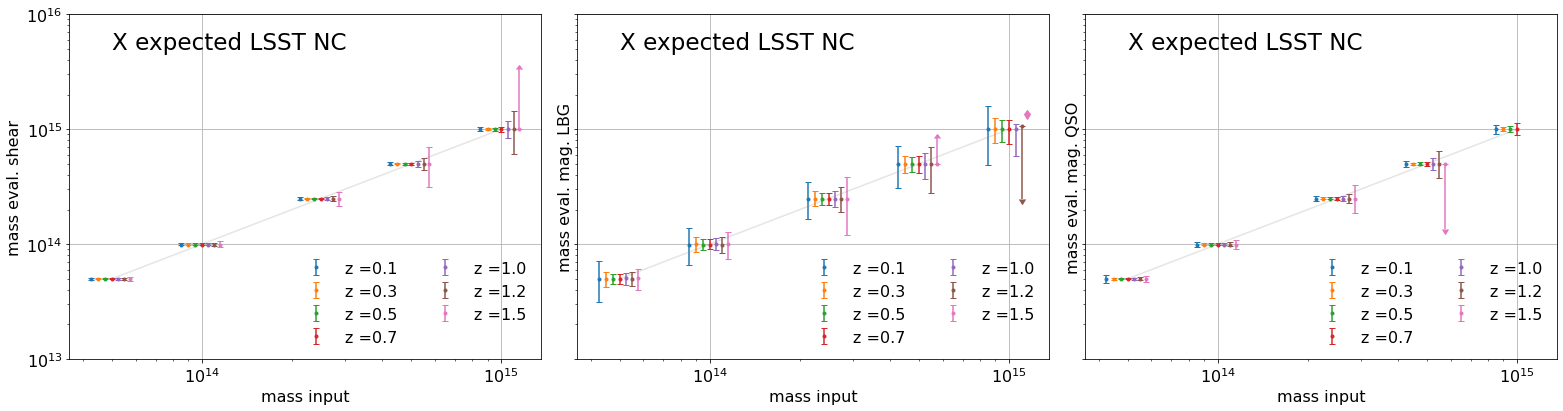

In [33]:
decal = 1 + np.linspace(-0.15,0.15,len(z_cl))

fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(22,6), sharex=True, sharey=True)

[ax1.errorbar(M200_cl*decal[i], eval_mass_s[:,i], yerr = [eval_mass_s[:,i] - eval_mass_min_s[:,i], eval_mass_max_s[:,i] - eval_mass_s[:,i]], \
 lolims=np.isnan(eval_mass_min_s[:,i]),  uplims=np.isnan(eval_mass_max_s[:,i]),  capsize=3, fmt='.', label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];



[ax2.errorbar(M200_cl*decal[i], eval_mass_mu_lbg[:,i], yerr = [eval_mass_mu_lbg[:,i] - eval_mass_min_mu_lbg[:,i], eval_mass_max_mu_lbg[:,i] - eval_mass_mu_lbg[:,i]],\
              lolims=np.isnan(eval_mass_min_mu_lbg[:,i]),  uplims=np.isnan(eval_mass_max_mu_lbg[:,i]),capsize=3, fmt='.', label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];

[ax3.errorbar(M200_cl*decal[i], eval_mass_mu_qso[:,i], yerr = [eval_mass_mu_qso[:,i] - eval_mass_min_mu_qso[:,i], eval_mass_max_mu_qso[:,i] - eval_mass_mu_qso[:,i]], \
               lolims=np.isnan(eval_mass_min_mu_qso[:,i]),  uplims=np.isnan(eval_mass_max_mu_qso[:,i]) ,capsize=3,  fmt='.', label="z =" +str(z_cl[i]) ) for i in range(len(lens_redshift))];
    
#[ax3.plot(M200_cl*decal[i], eval_mass_mu_qso[:,i],'.') for i in range(len(lens_redshift))];#, yerr = [eval_mass_mu_qso[:,i] - eval_mass_min_mu_qso[:,i], eval_mass_max_mu_qso[:,i] - eval_mass_mu_qso[:,i]], lolims=True, uplims=True ,fmt='.', label="z =" +str(z_cl[i]) ) for i in range(len(lens_redshift))];
  
    
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_ylabel("mass eval. shear");
ax2.set_ylabel("mass eval. mag. LBG");
ax3.set_ylabel("mass eval. mag. QSO");

for i in (ax1,ax2,ax3):
    i.plot(M200_cl, M200_cl,alpha=0.2)
    i.set_xlabel("mass input")
    i.grid()
    i.legend(loc='lower right',ncol=2,frameon=False)
    
N_S = N_LBG = N_QSO = "expected LSST NC"
#N_S = N_LBG = N_QSO = "one cluster"

ax1.text(5*1e13, 5e15, 'X ' + str(N_S), fontsize='x-large')
ax2.text(5*1e13, 5e15, 'X ' + str(N_LBG), fontsize='x-large')
ax3.text(5*1e13, 5e15, 'X ' + str(N_QSO), fontsize='x-large')

ax1.set_ylim(1e13,1e16)
fig.tight_layout()

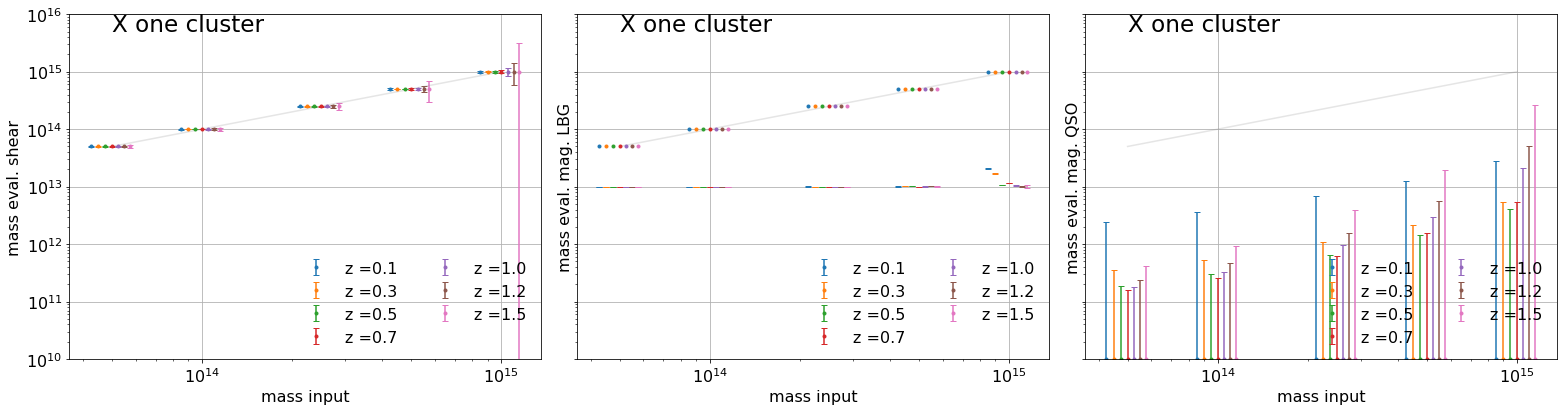

In [34]:
decal = 1 + np.linspace(-0.15,0.15,len(z_cl))

fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(22,6), sharex=True, sharey=True)

[ax1.errorbar(M200_cl*decal[i], mass_eval_s[:,i], yerr = [mass_eval_s[:,i] - mass_min_s[:,i], mass_max_s[:,i] - mass_eval_s[:,i]], \
 lolims=np.isnan(mass_eval_s[:,i]),  uplims=np.isnan(mass_eval_s[:,i]),  capsize=3, fmt='.', label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];

#[ax2.errorbar(M200_cl*decal[i], mass_eval_d[:,i], yerr = [mass_eval_d[:,i] - mass_min_d[:,i], mass_max_d[:,i] - mass_eval_d[:,i]], \
# lolims=np.isnan(mass_eval_d[:,i]),  uplims=np.isnan(mass_eval_d[:,i]),  capsize=3, fmt='.', label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];

[ax2.errorbar(M200_cl*decal[i], M200_cl, yerr = [M200_cl - mass_min_d[:,i], mass_max_d[:,i] - M200_cl], \
 lolims=np.isnan(mass_eval_d[:,i]),  uplims=np.isnan(mass_eval_d[:,i]),  capsize=3, fmt='.', label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))]


[ax3.errorbar(M200_cl*decal[i], mass_eval_z[:,i], yerr = [mass_eval_z[:,i] - mass_min_z[:,i], mass_max_z[:,i] - mass_eval_z[:,i]], \
 lolims=np.isnan(mass_eval_z[:,i]),  uplims=np.isnan(mass_eval_z[:,i]),  capsize=3, fmt='.', label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];


    
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_ylabel("mass eval. shear");
ax2.set_ylabel("mass eval. mag. LBG");
ax3.set_ylabel("mass eval. mag. QSO");

for i in (ax1,ax2,ax3):
    i.plot(M200_cl, M200_cl,alpha=0.2)
    i.set_xlabel("mass input")
    i.grid()
    i.legend(loc='lower right',ncol=2,frameon=False)
    
#N_S = N_LBG = N_QSO = "expected LSST NC"
N_S = N_LBG = N_QSO = "one cluster"

ax1.text(5*1e13, 5e15, 'X ' + str(N_S), fontsize='x-large')
ax2.text(5*1e13, 5e15, 'X ' + str(N_LBG), fontsize='x-large')
ax3.text(5*1e13, 5e15, 'X ' + str(N_QSO), fontsize='x-large')

ax1.set_ylim(1e10,1e16)
fig.tight_layout()

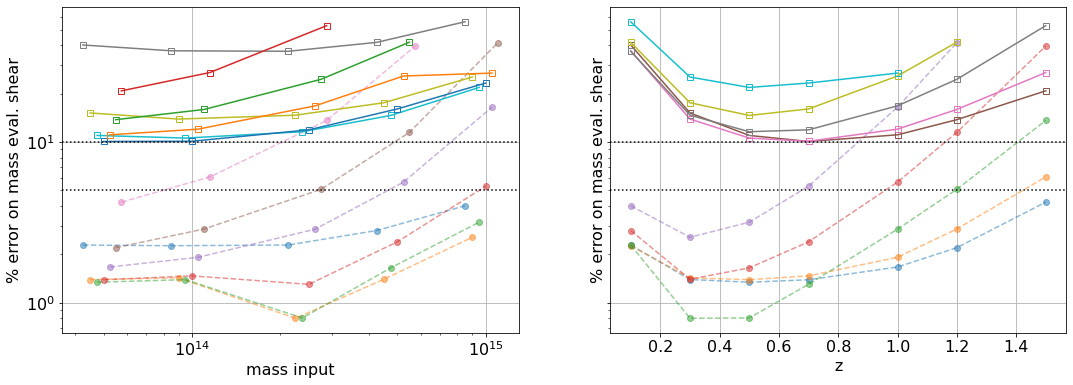

In [35]:
#relative error on mass from shear alone and shear + magnification (QSO & LBG) combined

fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(18,6), sharey=True)

[ax1.plot(M200_cl*decal[i], 100*0.5*(eval_mass_max_s[:,i]  - eval_mass_min_s[:,i])/ eval_mass_s[:,i] ,'o--', alpha=0.5, label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];
[ax1.plot(M200_cl*decal[i], 100*0.5*(eval_mass_max_mu_lbg[:,i]  - eval_mass_min_mu_lbg[:,i])/ eval_mass_mu_lbg[:,i] ,'s-' ,mfc='None' , alpha=1, label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];
#[ax1.plot(M200_cl*decal[i], 100*0.5*(eval_mass_max_comb_mu[:,i]  - eval_mass_min_comb_mu[:,i])/ eval_mass_comb_mu[:,i] ,'kx-',alpha=0.5) for i in range(len(lens_redshift))];

ax1.set_xscale('log')
#ax1.set_yscale('log')

ax1.set_xlabel("mass input")
ax1.set_ylabel("% error on mass eval. shear");
ax1.grid()

#ax1.legend(loc='best',ncol=2,frameon=False)
ax1.axhline(5, color='black', linestyle='dotted')
ax1.axhline(10, color='black', linestyle='dotted')

ax1.set_yscale('log')




[ax2.plot(z_cl, 100*0.5*(eval_mass_max_s[i,:]  - eval_mass_min_s[i,:])/ eval_mass_s[i,:] ,'o--', alpha=0.5, label="z =" +str(M200_cl[i])) for i in range(len(M200_cl))];
[ax2.plot(z_cl, 100*0.5*(eval_mass_max_mu_lbg[i,:]  - eval_mass_min_mu_lbg[i,:])/ eval_mass_mu_lbg[i,:] ,'s-' ,mfc='None' , alpha=1, label="z =" +str(M200_cl[i])) for i in range(len(M200_cl))];
#[ax2.plot(z_cl, 100*0.5*(eval_mass_max_comb_mu[i,:]  - eval_mass_min_comb_mu[i,:])/ eval_mass_comb_mu[i,:] ,'kx-',alpha=0.5) for i in range(len(M200_cl))];

#ax1.set_yscale('log')

ax2.set_xlabel("z")
ax2.set_ylabel("% error on mass eval. shear");
ax2.grid()

#ax1.legend(loc='best',ncol=2,frameon=False)
ax2.axhline(5, color='black', linestyle='dotted')
ax2.axhline(10, color='black', linestyle='dotted')
